In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import time

N=130       # Numero de cidades

rng = np.random.default_rng(seed=42)   # Define as posições aleatórias das cidades
x=rng.random(N)
y=rng.random(N)

# define o caminho que liga as cidades (inicialmente a sequencia como foi criada)
pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
    pathini[i]=i

In [2]:
#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))
            
    return dist

In [3]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho
    
    return ener

In [4]:
@jit(nopython=True)
def newpath(N,path):
    
    # define uma nova caminhada
    
    newpath = np.zeros(N,dtype=np.int16)

    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição 
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):        # inverte o sentido em que percorre o caminho entre os indices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]

    return newpath,ini,fin



In [5]:
@jit(nopython=True)
def mcstep(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)
    
    np1,ini,fin = newpath(N,path) # propoe um novo caminho
    
    # determina a diferença de energia 
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado até o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
            
    return en,path,best_e,best_p

In [13]:
def execution(df, Ti, Tf, passos_de_monte_carlo, N, caminho_inicial, x, y):
    count = 0
    temperatura = Ti
    distancia = distances(N, x, y)
    
    best_e = custo(N, caminho_inicial, distancia)
    en = best_e

    best_p = caminho_inicial
    caminho = caminho_inicial
    
    while(1):
        en, caminho, best_e, best_p = mcstep(N, 1/temperatura, en, caminho, best_e, best_p, distancia)
        
        if count > passos_de_monte_carlo:
            temperatura *= df
        
        if temperatura < Tf:
            break

        count += 1

    return best_p, best_e

In [16]:

caminho, distacia = execution(0.9, 10, 0.0001, 100, N,pathini, x, y)
# Tempo FInal

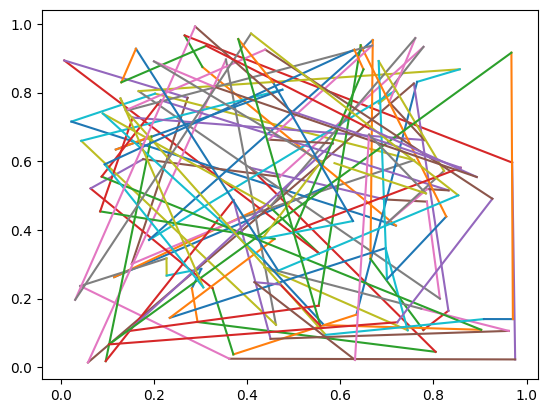

In [29]:
for cidade in range (len(caminho) - 1):
    plt.plot([x[caminho[cidade]], x[caminho[cidade+1]]],[y[caminho[cidade]], y[caminho[cidade+1]]])

In [22]:
print(caminho)

[113  59  14  16  51 107  90  46 116 111  84 117  67 102 103   5  96 124
  38  15  94  75  76  45  81  91   7  82  83 115  63  64  33  32  17 114
  34 104  29 105  35  39  53  24  44  20  74  21  87  27  37  98  25 108
  10   9  99   0  40  30   3  73  56 122  28  55  54   6 106  85  69  62
 109  97  70  41  52 101  13  48  42  18  12  65 127 120  92  60  58  57
 100  22  31 128  86  11   1  49   8 112   4  95 121  89   2 125  47  68
  71  72  26  88  36  43  80  23 126  50  66 118 119 110  93  78  61 123
  19  77  79 129]
